In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

In [2]:
# Load scaled data
scaled_df = pd.read_csv(
    r"C:\Users\Vanitha\OneDrive\Documents\GUVI\capstone_project\app_user_behavior_segmentation\data\cleaned\scaled_for_clustering.csv"
) 

In [3]:
# Feature Selection
behavior_features = [
    'sessions_per_week',
    'avg_session_duration_min',
    'daily_active_minutes',
    'engagement_score',
    'churn_risk_score',
    'days_since_last_login'
]

behavior_df = scaled_df[behavior_features] 

In [4]:
# Outlier removal
z_scores = np.abs(zscore(behavior_df))
filtered_df = behavior_df[(z_scores < 3).all(axis=1)] 

In [5]:
# Finding Optimal K Using Silhouette Score
silhouette_scores = {}

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(filtered_df)
    sil = silhouette_score(filtered_df, labels)
    silhouette_scores[k] = sil
    print(f"K = {k}, Silhouette Score = {sil}") 

K = 2, Silhouette Score = 0.1323339180603307
K = 3, Silhouette Score = 0.11898299841382337
K = 4, Silhouette Score = 0.1211775350801963
K = 5, Silhouette Score = 0.12014686131640323
K = 6, Silhouette Score = 0.11938679030696488
K = 7, Silhouette Score = 0.12290479435713576


In [18]:
# Final Clustering(MinibatchKMeans)
best_k = max(silhouette_scores, key=silhouette_scores.get)

kmeans = MiniBatchKMeans(n_clusters=best_k, batch_size=256, random_state=42)
final_clusters = kmeans.fit_predict(filtered_df) 

pd.Series(final_clusters).value_counts() 

1    25032
0    23928
Name: count, dtype: int64

In [10]:
# Final improved Silhouette Score
final_silhouette = silhouette_score(filtered_df, final_clusters)
print("Final Improved Silhouette Score:", final_silhouette) 

Final Improved Silhouette Score: 0.1308970526079486


In [21]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
hier_labels = hierarchical.fit_predict(filtered_df)

pd.Series(hier_labels).value_counts() 

0    31344
1    17616
Name: count, dtype: int64

In [22]:
# Hierarchical Silhouette Score
hier_sil = silhouette_score(filtered_df, hier_labels)
print("Hierarchical Silhouette Score:", hier_sil) 

Hierarchical Silhouette Score: 0.06681155439461514


In [23]:
# BIRCH Clustering
birch = Birch(n_clusters=best_k)
birch_labels = birch.fit_predict(filtered_df)

pd.Series(birch_labels).value_counts()  

0    43088
1     5872
Name: count, dtype: int64

In [24]:
# BIRCH Silhouette Score
birch_sil = silhouette_score(filtered_df, birch_labels)
print("BIRCH Silhouette Score:", birch_sil) 

BIRCH Silhouette Score: 0.10796378284466916


## Insights of Comparing 3 Clustering models
1. Comparing to MiniBatchKmeans, Hierarchical and BIRCH Clustering models, I found MiniBatchKMeans is the best model.
2. It provides the good user behavioral Silhouette Score.
3. MiniBatchKMeans is faster, scalable, & more robust to noise.
4. It produces near optimal clusters while significantly reducing computation time, making it suitable for industry scale datasets.

## Comparing K-Means and MiniBathchKMeans clustering...
--> MiniBatchKMeans is a variant(Optimized version) of K-Means, not a completely different algorithym.
--> Both aim to minimize the same objective function but they differ in how centroids are updated. 

In [11]:
# PCA visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_df)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_)) 

Explained Variance Ratio: [0.17618568 0.17386981]
Total Variance Explained: 0.3500554919390413


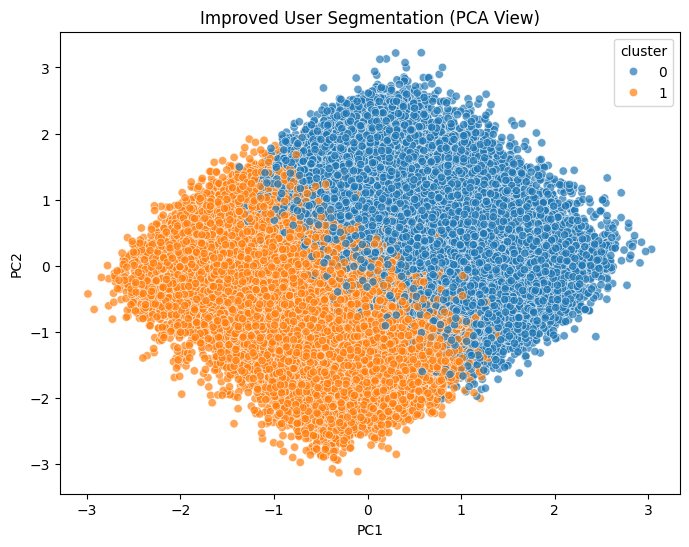

In [12]:
# MiniBatchKMeans PCA Visualization
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['cluster'] = final_clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='tab10', alpha=0.7)
plt.title("Improved User Segmentation (PCA View)")
plt.show() 

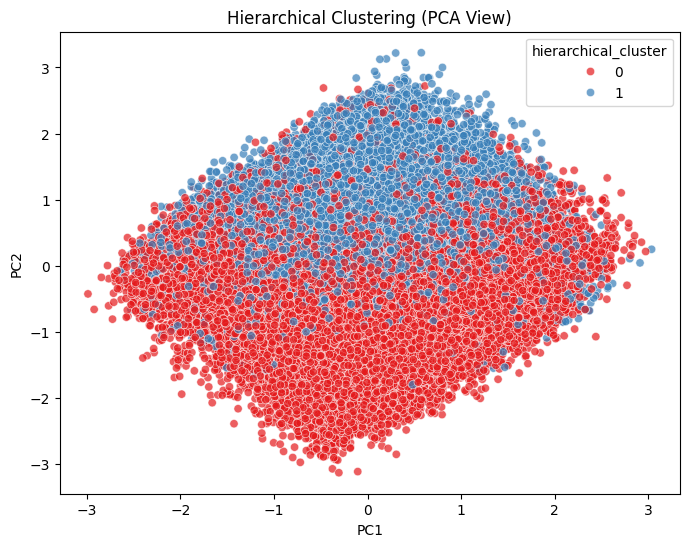

In [ ]:
# Hierarchical PCA Visualization
pca_df['hierarchical_cluster'] = hier_labels

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='hierarchical_cluster', data=pca_df, palette='Set1', alpha=0.7)
plt.title("Hierarchical Clustering (PCA View)")
plt.show() 

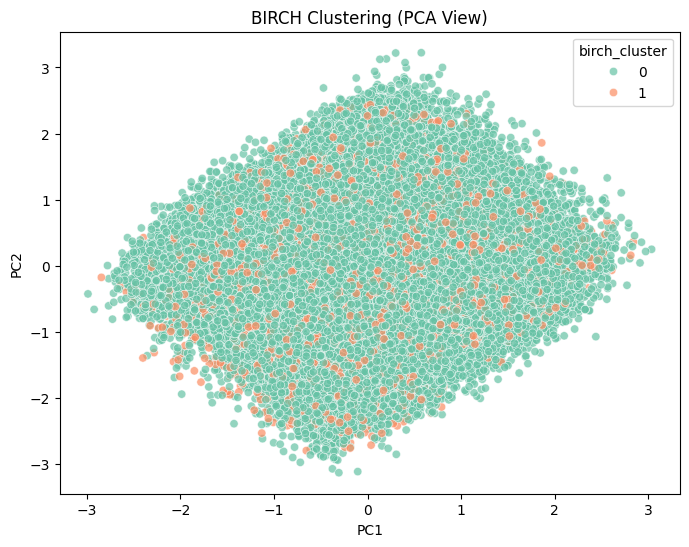

In [17]:
# BIRCH PCA Visualization
pca_df['birch_cluster'] = birch_labels

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='birch_cluster', data=pca_df, palette='Set2', alpha=0.7)
plt.title("BIRCH Clustering (PCA View)")
plt.show() 